# Homework nr. 2 - data cleaning (deadline 8/11/2018)

In short, the main task is to clean The Metropolitan Museum of Art Open Access dataset.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can. ;)

## What are you supposed to do:

  1. Download the dataset MetObjects.csv from the repository https://github.com/metmuseum/openaccess/.
  2. Check consistency of at least three features where you expect problems (include "Object Name" feature).
  3. Select some features where you expect integrity problems (describe your choice) and check integrity of those features.
  4. Convert at least five features to a proper data type. Choose at least one numeric, one categorical and one datetime.
  5. Find some outliers (describe your selection criteria).
  6. Detect missing data in at least three features, convert them to a proper representation (if they are already not), and impute missing values in at least one feature.

**If you do all this properly, you will obtain 6 points**

To earn **extra two points** you can do some of these:
  * Focus more precisely on cleaning of the "Medium" feature. Such if you like to use it in KNN based algorithms later.
  * Focus on the extraction of physical dimensions of each item (width, depth and height in centimeters) from the "Dimensions" feature.

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

In [1]:
### here comes your code
import numpy as np
import pandas as pd
import sklearn as skit
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.stats import chi2_contingency

import seaborn as sns
import re

import matplotlib
import matplotlib.pyplot as plt

import datetime as dt

%matplotlib inline

In [2]:
df = pd.read_csv('MetObjects.csv')

C:\Programs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7,8,9,10,11,18,27,28,29,30,31,32,33,34,35,36,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(len(df))
display(df.info())

472463
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472463 entries, 0 to 472462
Data columns (total 43 columns):
Object Number              472463 non-null object
Is Highlight               472463 non-null bool
Is Public Domain           472463 non-null bool
Object ID                  472463 non-null int64
Department                 472463 non-null object
Object Name                468469 non-null object
Title                      441395 non-null object
Culture                    192260 non-null object
Period                     73157 non-null object
Dynasty                    23307 non-null object
Reign                      11214 non-null object
Portfolio                  21828 non-null object
Artist Role                281547 non-null object
Artist Prefix              96697 non-null object
Artist Display Name        282766 non-null object
Artist Display Bio         235279 non-null object
Artist Suffix              10748 non-null object
Artist Alpha Sort          282737 non-null 

None

## Data consistency

In [4]:

df.nunique()

Object Number              469797
Is Highlight                    2
Is Public Domain                2
Object ID                  472463
Department                     19
Object Name                 27888
Title                      246256
Culture                      7189
Period                       1768
Dynasty                       378
Reign                         376
Portfolio                    3182
Artist Role                  6258
Artist Prefix                5534
Artist Display Name         60864
Artist Display Bio          44903
Artist Suffix                1700
Artist Alpha Sort           60870
Artist Nationality           3806
Artist Begin Date           23765
Artist End Date             24094
Object Date                 32266
Object Begin Date            2105
Object End Date              2079
Medium                      64554
Dimensions                 253824
Credit Line                 38722
Geography Type                132
City                         2664
State         

In [5]:
pd.set_option('display.max_rows', 25)
display(df["Object Name"].value_counts())

Print                                    99314
Photograph                               29497
Drawing                                  25411
Book                                     13469
Fragment                                  9665
Piece                                     8632
Painting                                  6095
Negative                                  5940
Baseball card, print                      5542
Baseball card                             4611
Bowl                                      3560
Figure                                    3115
                                         ...  
Tablet of Julia Donata                       1
Coffin foot, fish drawing                    1
Cosmetic, spoon                              1
Brooch with pendant                          1
Robe, Dancer's                               1
Grave stele of Demetrios                     1
Dagger (Golok or pedang) with sheath         1
Double uraeus (?), disk and horns (?)        1
Sphinx, Senwo

##### It seems that there is at few problems 
 - I expect Baseball card, print and Print baseball card  to be same thing
 - What is the difference between Print and Print; ephemera , is it considerable difference?
 - Do we really need so many names for Baseball cards
 - i Supose that further analysis will find many more

In [6]:
df[df['Object Name'].str.contains("[Bb]aseball", na=False)]['Object Name'].value_counts()

Baseball card, print         5542
Baseball card                4611
Baseball card, photograph    2141
Print baseball card          1942
Print, baseball               922
Print, baseball card          397
Album, baseball                88
Photograph, baseball card      36
Photograph baseball card       33
Baseball, print                10
Name: Object Name, dtype: int64

##### This demonstrates problem of baseball cards consistency

In [7]:
df[df['Object Name'].str.contains("[Pp]rint", na=False)]['Object Name'].value_counts()

Print                                                 99314
Baseball card, print                                   5542
Books Prints Ornament & Architecture                   2127
Print baseball card                                    1942
Print; ephemera                                        1634
Print collection ornament & architecture               1481
Print Ornament & Architecture                          1135
Print, baseball                                         922
Woodblock print                                         778
Book Print Ornament & Architecture                      759
Print ornament & architecture                           732
Book Prints Ornament & Architecture                     487
                                                      ...  
Print , Collage                                           1
Print collection ornamnet & architecture                  1
Print cabinet                                             1
Album; Ornament and architecture ; drawi

#### Similar for printed stuff, its almost impossible to tell whether is should be unique category or it should be grouped with "Print"

In [ ]:
display(df["Dynasty"].value_counts())

Dynasty column have consistency problem.
I supose that correct format is Dynasty %dynasty_in-%dynasty_max
This can be splited to two int columns by using regex it will be easier to query 

In [9]:
display(df["Department"].value_counts())

Drawings and Prints                          173923
European Sculpture and Decorative Arts        42963
Photographs                                   38901
Asian Art                                     37304
Costume Institute                             31386
Egyptian Art                                  27918
American Decorative Arts                      18454
Greek and Roman Art                           17431
Islamic Art                                   15776
Modern and Contemporary Art                   14512
Arms and Armor                                13578
Arts of Africa, Oceania, and the Americas     12963
Medieval Art                                   7488
Ancient Near Eastern Art                       6186
Musical Instruments                            5316
European Paintings                             2936
The Cloisters                                  2628
Robert Lehman Collection                       2586
The Libraries                                   214
Name: Depart

##### Department column seems to be ok 

# Integrity check

I supose there must be overlap in date of birth and date of death of artist and suposed date of object so lets check that,
Also i supose minimal lifespan of artist 25 years...

In [10]:
df = df.rename(columns={'Artist Begin Date': 'a_beg', 'Artist End Date': 'a_end','Object Date':'o_d','Object Begin Date':'o_bd','Object End Date' : 'o_ed'})

df.a_beg = pd.to_numeric(df.a_beg,errors ='coerce')
df.a_end = pd.to_numeric(df.a_end,errors ='coerce')
df.o_d = pd.to_numeric(df.o_d,errors ='coerce')
df.o_ed = pd.to_numeric(df.o_ed,errors ='coerce')
df.o_bd = pd.to_numeric(df.o_bd,errors ='coerce')



df[(df.a_end - df.a_beg) < 25 & np.isfinite(df.a_beg) & np.isfinite(df.a_end) ].filter(['a_beg','a_end','o_d','o_bd','o_ed'], axis=1)[:15]

a_beg   a_end     o_d  o_bd  o_ed
299   1849.0  1849.0     NaN  1849  1858
300   1849.0  1849.0     NaN  1846  1858
302   1852.0  1852.0     NaN  1846  1858
379   1849.0  1849.0     NaN  1849  1858
462   1852.0  1852.0     NaN  1852  1858
494   1852.0  1852.0     NaN  1850  1858
495   1852.0  1852.0     NaN  1846  1858
496   1852.0  1852.0  1849.0  1849  1849
1237  1852.0  1852.0     NaN  1849  1858
1238  1852.0  1852.0     NaN  1849  1858
1379  1849.0  1849.0     NaN  1849  1858
1403  1852.0  1852.0     NaN  1849  1858
1972  1849.0  1849.0     NaN  1846  1858
2114  1849.0  1849.0     NaN  1849  1849
2115  1849.0  1849.0     NaN  1849  1849

##### Some of hte dates look suspicious maybe the authors are not actual persons since data above does not look like birth and death dates
##### also some of them does not even look like year but that is consistency problem

In [11]:
df[ np.isfinite(df.a_beg) & np.isfinite(df.a_end) & ((df.a_end < df.o_d) | (df.a_beg > df.o_d)) ].filter(['a_beg','a_end','o_d','o_bd','o_ed'], axis=1)[:15]

a_beg   a_end     o_d  o_bd  o_ed
1     1785.0  1844.0  1901.0  1901  1901
10    1785.0  1844.0  1907.0  1907  1907
11    1794.0  1869.0  1876.0  1876  1876
13    1785.0  1844.0  1907.0  1907  1907
210   1829.0  1835.0  1859.0  1859  1859
211   1829.0  1835.0  1859.0  1859  1859
420   1725.0  1792.0  1815.0  1815  1815
496   1852.0  1852.0  1849.0  1849  1849
1558  1829.0  1835.0  1859.0  1859  1859
1670  1829.0  1835.0  1859.0  1859  1859
1671  1829.0  1835.0  1859.0  1859  1859
1672  1829.0  1835.0  1859.0  1859  1859
1673  1829.0  1835.0  1859.0  1859  1859
2164  1852.0  1852.0  1849.0  1849  1849
4670  1740.0  1799.0  1819.0  1819  1819

In [12]:
len(df[ np.isfinite(df.a_beg) & np.isfinite(df.a_end) & ((df.a_end < df.o_d) | (df.a_beg > df.o_d)) ].filter(['a_beg','a_end','o_d','o_bd','o_ed'], axis=1))

1839

##### OK! There is 1839 objects with date of origin outside of the artist life i supose this could be integrity problem!!!!

# Type conversions

##### Convert metadata date from string to real date

In [13]:
df['Metadata Date'] = pd.to_datetime(df['Metadata Date'], format='%d/%m/%Y %H:%M:%S AM')

In [14]:
display(df['Metadata Date'].dtype)

dtype('<M8[ns]')

In [15]:
df['Metadata Date'][:5]

0   2018-05-11 08:00:02
1   2018-05-11 08:00:02
2   2018-05-11 08:00:02
3   2018-05-11 08:00:02
4   2018-05-11 08:00:02
Name: Metadata Date, dtype: datetime64[ns]

Below i ignore values that can not be converted to desired type

In [16]:
df.a_beg = pd.to_numeric(df.a_beg,errors ='coerce')
df.a_end = pd.to_numeric(df.a_end,errors ='coerce')
df.o_d = pd.to_numeric(df.o_d,errors ='coerce')
df.o_ed = pd.to_numeric(df.o_ed,errors ='coerce')
df.o_bd = pd.to_numeric(df.o_bd,errors ='coerce')

# Outliers

In [17]:
df.apply(['min', 'max'])

Object Number  Is Highlight  Is Public Domain  Object ID  \
min        00.1.1         False             False          1   
max         x.815          True              True     817364   

                   Department   a_beg   a_end     o_d    o_bd    o_ed  \
min  American Decorative Arts -1279.0 -1213.0     0.0 -400000 -240000   
max             The Libraries  2013.0  9999.0  2018.0    5000  157555   

                                         Link Resource       Metadata Date  \
min   http://www.metmuseum.org/art/collection/search/1 2018-05-11 08:00:02   
max  http://www.metmuseum.org/art/collection/search... 2018-05-11 08:00:02   

                                   Repository  
min  Metropolitan Museum of Art, New York, NY  
max  Metropolitan Museum of Art, New York, NY

##### It seems that dates have some serious outliers even negative values lets plot this

In [18]:
df[np.isfinite(df.a_end)].a_end

0         1869.0
1         1844.0
9         1917.0
10        1844.0
11        1869.0
12        1917.0
13        1844.0
32        1930.0
33        1853.0
35        1932.0
36        1795.0
37        1795.0
           ...  
472414    1600.0
472415    1600.0
472417    1600.0
472435    1600.0
472437    1600.0
472443    1600.0
472447    1600.0
472449    1600.0
472451    1600.0
472456    1515.0
472457    1570.0
472462    1955.0
Name: a_end, Length: 168459, dtype: float64

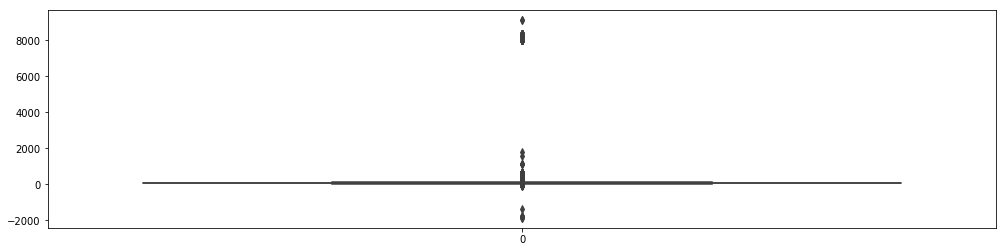

In [19]:
plt.figure(figsize=(17, 4))
sns.boxplot(data=(df.a_end - df.a_beg))

###### there are some weird outliers in age of artists some of them are tousands year old. So there is maybe something fishy

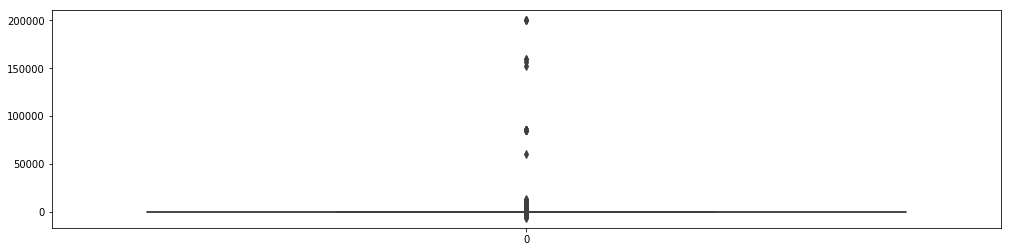

In [20]:
plt.figure(figsize=(17, 4))
sns.boxplot(data=(df.o_ed - df.o_bd))

##### Simlar for objects age but in this case those are maybe estimations

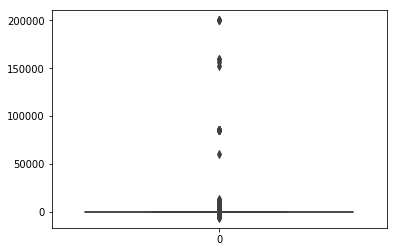

In [21]:
sns.boxplot(data=(df.o_ed - df.o_bd))

C:\Programs\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


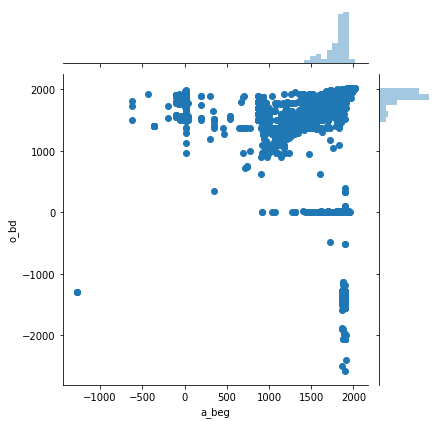

In [22]:
sns.jointplot(x='a_beg', y='o_bd', data = df)

##### This hsould be more or les diagonal line especialy veird is Object data -2000 whe author begin date is 2000 that is most likely intgrity issue

# Missing data

In [23]:
df.isnull().sum()[:]

Object Number                   0
Is Highlight                    0
Is Public Domain                0
Object ID                       0
Department                      0
Object Name                  3994
Title                       31068
Culture                    280203
Period                     399306
Dynasty                    449156
Reign                      461249
Portfolio                  450635
                            ...  
Country                    395897
Region                     440664
Subregion                  450311
Locale                     456906
Locus                      465138
Excavation                 456500
River                      470365
Classification              56433
Rights and Reproduction    448171
Link Resource                   0
Metadata Date                   0
Repository                      0
Length: 43, dtype: int64

### KNN for missing Object names

In [24]:
df = df.rename(columns={'Artist Display Name': 'a_dn','Object Name':'o_name'})

In [ ]:
# choose columns to compute nearest neighbors
NNcolumns = ['o_name','a_dn','Department']

# get data into numpy array
data = df.loc[:, NNcolumns].copy()
for column in data.select_dtypes(['category']).columns:
    data[column] = data[column].cat.codes

display(data)

#### From table above its possible to see that same author and department shold provide good chance of guessing the object name using KNN

In [ ]:
# transform categories to indicators
data = pd.get_dummies(data,columns=NNcolumns)
print(data)

# X - points where we know the Age
X = data[df.o_name == False].values
display(X)

In [ ]:
Xidx = data[df.o_name == False].index

# Y - points where the Age should be imputed
Y = data[df.o_name == True].values
Yidx = data[df.o_name == True].index

# training with 5 neighbours
neighbors = NearestNeighbors(5)
neighbors.fit(X)

# get 5 neighbors for each point
Yn = neighbors.kneighbors(Y, return_distance=False)

##### Unfortunately i did not make this work